In [1]:
import os
import re
import sys
import time
import math
import random
import pickle
from collections import Counter,OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as U
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0
print(device)

cuda


#####**Download IMDB Dataset** 



In [2]:
!wget https://raw.githubusercontent.com/avinashsai/Recurrent-Neural-Filters/master/Datasets/IMDB/testneg.txt
!wget https://raw.githubusercontent.com/avinashsai/Recurrent-Neural-Filters/master/Datasets/IMDB/testpos.txt
!wget https://raw.githubusercontent.com/avinashsai/Recurrent-Neural-Filters/master/Datasets/IMDB/trainneg.txt
!wget https://raw.githubusercontent.com/avinashsai/Recurrent-Neural-Filters/master/Datasets/IMDB/trainpos.txt

--2020-02-01 12:41:49--  https://raw.githubusercontent.com/avinashsai/Recurrent-Neural-Filters/master/Datasets/IMDB/testneg.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16079828 (15M) [text/plain]
Saving to: ‘testneg.txt’

testneg.txt         100%[===================>]  15.33M  75.5MB/s    in 0.2s    

2020-02-01 12:41:51 (75.5 MB/s) - ‘testneg.txt’ saved [16079828/16079828]

--2020-02-01 12:41:53--  https://raw.githubusercontent.com/avinashsai/Recurrent-Neural-Filters/master/Datasets/IMDB/testpos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response...

##### **Path to Data and glove embeddings. Change vecpath if glove embeddings are in a different path**

In [0]:
datapath = ''
vecpath = 'glove.840B.300d.txt'

##### **Comment out first 3 lines if glove embeddings are already downloaded**

In [0]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!rm -rf glove.840B.30d.zip

embedding_index = {}
with open(vecpath,'r',encoding='utf-8') as f:
    for line in f.readlines():
      words = line.split(' ')
      word = words[0]
      v = torch.from_numpy(np.asarray([w for w in words[1:]],'float32'))
      embedding_index[word] = v

##### **Parameters Required to train**

In [0]:
maxlen = 300
embeddim = 300
numclasses = 2
batchsize = 64
epochs = 50

In [0]:
## Preprocess Text
def preprocess(text):
  text = str(text)
  text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)     
  text = re.sub(r"\'s", " \'s", text) 
  text = re.sub(r"\'ve", " \'ve", text) 
  text = re.sub(r"n\'t", " n\'t", text) 
  text = re.sub(r"\'re", " \'re", text) 
  text = re.sub(r"\'d", " \'d", text) 
  text = re.sub(r"\'ll", " \'ll", text) 
  text = re.sub(r",", " , ", text) 
  text = re.sub(r"!", " ! ", text) 
  text = re.sub(r"\(", " \( ", text) 
  text = re.sub(r"\)", " \) ", text) 
  text = re.sub(r"\?", " \? ", text) 
  text = re.sub(r"\s{2,}", " ", text)
  text = re.sub(r"<br>"," ",text)
  text = re.sub(r"it\'s","it is",str(text))
  text = re.sub(r"i\'d","i would",str(text))
  text = re.sub(r"don\'t","do not",str(text))
  text = re.sub(r"he\'s","he is",str(text))
  text = re.sub(r"there\'s","there is",str(text))
  text = re.sub(r"that\'s","that is",str(text))
  text = re.sub(r"can\'t", "can not", text)
  text = re.sub(r"cannot", "can not ", text)
  text = re.sub(r"what\'s", "what is", text)
  text = re.sub(r"What\'s", "what is", text)
  text = re.sub(r"\'ve ", " have ", text)
  text = re.sub(r"n\'t", " not ", text)
  text = re.sub(r"i\'m", "i am ", text)
  text = re.sub(r"I\'m", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'s"," is",text)    
  return text.strip().lower()

In [7]:
traindata = []
poscount = 0
negcount = 0
with open(datapath+'trainpos.txt','r',encoding='latin1') as f:
  for line in f.readlines():
    traindata.append(preprocess(line[:-1]))
    poscount+=1

with open(datapath+'trainneg.txt','r',encoding='latin1') as f:
  for line in f.readlines():
    traindata.append(preprocess(line[:-1]))
    negcount+=1

trainlabels = np.zeros(poscount+negcount)
trainlabels[:poscount] = 1

print("Number of Positive polarity Samples {} ".format(poscount))
print("Number of Negative polarity Samples {} ".format(negcount))


Number of Positive polarity Samples 12500 
Number of Negative polarity Samples 12500 


In [8]:
testdata = []
poscount = 0
negcount = 0
with open(datapath+'testpos.txt','r',encoding='latin1') as f:
  for line in f.readlines():
    testdata.append(preprocess(line[:-1]))
    poscount+=1

with open(datapath+'testneg.txt','r',encoding='latin1') as f:
  for line in f.readlines():
    testdata.append(preprocess(line[:-1]))
    negcount+=1

testlabels = np.zeros(poscount+negcount)
testlabels[:poscount] = 1

print("Number of Positive polarity Samples {} ".format(poscount))
print("Number of Negative polarity Samples {} ".format(negcount))


Number of Positive polarity Samples 12500 
Number of Negative polarity Samples 12500 


In [9]:
traindata,trainlabels = shuffle(traindata,trainlabels,random_state=0)  ## Shuffle Data for not inducing bias into training data
testdata,testlabels = shuffle(testdata,testlabels,random_state=0)
traindata, valdata, trainlabels, vallabels = train_test_split(traindata,trainlabels,test_size=0.2,random_state=42)
print("Training Data Size: {} ".format(len(traindata)))
print("Validation Data Size: {} ".format(len(valdata)))
print("Testing Data Size: {} ".format(len(testdata)))

Training Data Size: 20000 
Validation Data Size: 5000 
Testing Data Size: 25000 


In [0]:
trainlabels = torch.from_numpy(trainlabels)  # Converting Numpy Labels to Torch Labels
vallabels = torch.from_numpy(vallabels)
testlabels = torch.from_numpy(testlabels)

##### **Takes list of sentences as argument an returns vocabulary**

In [0]:
def get_vocab(corpus):
  words = []
  for sentence in corpus:
    words+=sentence.split()
  counts = Counter(words).most_common()
  counts.insert(0,('<PAD>',0)) ## Index 0 for PAD word
  counts.insert(1,('<UNK>',1))  ## Index 1 for OOV word
  vocabulary = {}
  vocabulary = {word:i for i,(word,_) in enumerate(counts)}
  return vocabulary

In [12]:
vocab = get_vocab(traindata)
print("Vocabulary Size is :",len(vocab))

Vocabulary Size is : 74270


##### **Converts each sentences to corresponding Indices in vocabulary**

In [0]:
def get_vectors(sentence,vocabulary):
  temp = [vocabulary[word] for word in sentence.split() if word in vocabulary]
  vector = [0] * maxlen   ## Pads the sentence to maxlen
  curlen = len(temp)
  if(maxlen-curlen<0):
      vector = temp[:maxlen]
  else:
      vector[maxlen-curlen:] = temp

  return torch.from_numpy(np.asarray(vector,dtype='int32'))

In [0]:
def get_data(data,vocabulary):
  vectors = torch.zeros(len(data),maxlen)
  for i in range(len(data)):
      vectors[i] = get_vectors(data[i],vocabulary)
  return vectors

In [0]:
trainindices = get_data(traindata,vocab)  ## Training data Indices
valindices = get_data(valdata,vocab)    ## Validation data Indices
testindices = get_data(testdata,vocab)   ## Testing data Indices

In [16]:
trainindices.size(),valindices.size(),testindices.size()

(torch.Size([20000, 300]), torch.Size([5000, 300]), torch.Size([25000, 300]))

In [0]:
trainarray = U.TensorDataset(trainindices,trainlabels)
trainloader = U.DataLoader(trainarray,batch_size=batchsize)  ## Train Loader 

valarray = U.TensorDataset(valindices,vallabels)
valloader = U.DataLoader(valarray,batch_size=batchsize) ## Validation Loader 

testarray = U.TensorDataset(testindices,testlabels)
testloader = U.DataLoader(testarray,batch_size=batchsize) ## Test Loader 

In [18]:
len(trainloader),len(valloader),len(testloader)

(313, 79, 391)

In [0]:
embedding_matrix = torch.zeros(len(vocab),embeddim).to(device)
for i,word in enumerate(vocab):
  embedding_vector = embedding_index.get(word)
  if(embedding_vector is not None):
    embedding_matrix[i] = embedding_vector
  elif(word!='<PAD>'):
    embedding_matrix[i] = torch.from_numpy(np.random.normal(0,0.1,embeddim)) 

In [20]:
embedding_matrix.size()

torch.Size([74270, 300])

In [0]:
class RMSNorm(nn.Module):
  def __init__(self,size,epsilon=1e-5):
    super(RMSNorm,self).__init__()
    self.gain = nn.Parameter(torch.ones(size))   ## Gain
    self.biass = nn.Parameter(torch.zeros(size))  ## Bias
    self.epsilon = epsilon
  
    self.register_parameter('gain',self.gain)
    self.register_parameter('biass',self.biass)

  def forward(self,x):
    x_std = torch.sqrt(torch.mean(x**2,-1,keepdim=True))    ## STD of Tensor along last dimension

    x_norm = x /(x_std + self.epsilon)  ## Normalization
    x_norm = x_norm * self.gain + self.biass  ## Normalized Tensor
    return x_norm

In [0]:
hidden1 = 300
hidden2 = 200

In [0]:
class ModelwithLayerNorm(nn.Module):
  def __init__(self):
    super(ModelwithLayerNorm,self).__init__()
    self.hiddendim1 = hidden1
    self.hiddendim2 = hidden2
    self.maxlen = maxlen
    self.embeddim = embeddim
    self.numclasses = numclasses
    self.embed = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
    self.lstm1 = nn.LSTM(self.embeddim,self.hiddendim1,batch_first=True)
    self.lstm2 = nn.LSTM(self.hiddendim1,self.hiddendim2,batch_first=True)
    self.fc = nn.Linear(self.hiddendim2,numclasses)
    self.ln1 = nn.LayerNorm(self.hiddendim1)   ## Layer Norm on First LSTM
    self.ln2 = nn.LayerNorm(self.hiddendim2)   ## Layer Norm on Second LSTM

  def forward(self,x):
    x = self.embed(x)
    out,_ = self.lstm1(x)
    out = self.ln1(out)
    out,_ = self.lstm2(out)
    out = self.ln2(out)
    out = self.fc(out[:,-1,:])
    return out

In [0]:
class ModelwithRMSNorm(nn.Module):
  def __init__(self):
    super(ModelwithRMSNorm,self).__init__()
    self.hiddendim1 = hidden1
    self.hiddendim2 = hidden2
    self.maxlen = maxlen
    self.embeddim = embeddim
    self.numclasses = numclasses
    self.embed = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
    self.lstm1 = nn.LSTM(self.embeddim,self.hiddendim1,batch_first=True)
    self.lstm2 = nn.LSTM(self.hiddendim1,self.hiddendim2,batch_first=True)
    self.fc = nn.Linear(self.hiddendim2,numclasses)
    self.ln1 = RMSNorm(self.hiddendim1)   ## RMS Norm on First LSTM
    self.ln2 = RMSNorm(self.hiddendim2)   ## RMS Norm on Second LSTM

  def forward(self,x):
    x = self.embed(x)
    out,_ = self.lstm1(x)
    out = self.ln1(out)
    out,_ = self.lstm2(out)
    out = self.ln2(out)
    out = self.fc(out[:,-1,:])
    return out

In [0]:
def evaluate(model,loader):
  curloss = 0.0
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for indices,labels in loader:
      indices = indices.long().to(device)
      labels = labels.long().to(device)

      total+=indices.size(0)
      output = model(indices)
      loss = F.cross_entropy(output,labels,reduction='sum')
      curloss+=loss.item()
      output = torch.max(output,1)[1]
      correct+=torch.sum(labels==output).item()

    return round((curloss/total),3),round(((correct/total)*100),2)

In [52]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model1 = ModelwithLayerNorm().to(device)
optim1 = optim.Adam(model1.parameters(),lr=0.003)

model2 = ModelwithRMSNorm().to(device)
optim2 = optim.Adam(model2.parameters(),lr=0.003)

model1trainloss = []  # Layer Norm Model Train Loss
model2trainloss = []  # RMS Norm Model Train Loss
model1trainacc = []   # Layer Norm Model Train Accuracy
model2trainacc = []   # RMS Norm Model Train Accuracy
model1valloss = []   # Layer Norm Model val Loss
model2valloss = []   # RMS Norm Model val Loss
model1valacc = []   # Layer Norm Model Val Accuracy
model2valacc = []  # RMS Norm Model Val Accuracy

patience = 20    ## Early Stopping Patience
curpatience = patience

print("Training Model with RMS Normalization ")
print("--------------------------------------------------------------------")
curpatience = patience
best_model_wts = deepcopy(model2.state_dict())
bestvalloss = np.Inf
steps2 = 0
epochs2 = 0
model2.train()
for epoch in range(1,epochs+1):
  model2.train()
  curtrainloss = 0.0
  for trainindices,trainlab in trainloader:
    trainindices,trainlab = trainindices.long().to(device),trainlab.long().to(device)
    model2.zero_grad()
    output = model2(trainindices)
    loss = F.cross_entropy(output,trainlab,reduction='mean')
    loss.backward()
    optim2.step()
    model2trainloss.append(loss.item())
    curtrainloss+=loss.item()
    steps2+=1
  epochs2+=1
  _, curtrainacc = evaluate(model2,trainloader)
  curvalloss,curvalacc = evaluate(model2,valloader)
  print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,round(curtrainloss/len(trainloader),3),curtrainacc))
  print("Validation Loss {} Validation Accuracy {} ".format(curvalloss,curvalacc))
  print("-----------------------------------------------------------------------------------")
  model2valloss.append(curvalloss)
  model2valacc.append(curvalacc)
  if(curvalloss<bestvalloss):
    bestvalloss = curvalloss 
    best_model_wts = deepcopy(model2.state_dict())
    curpatience = patience
  else:
    curpatience = curpatience - 1
    if(curpatience==0):
      break

model2 = ModelwithRMSNorm().to(device)
model2.load_state_dict(best_model_wts)
testloss,testacc = evaluate(model2,testloader)
print("Test Accuracy (With RMS Normalization) {} ".format(testacc))
print("----------------------------------------------------------------------------------")

Training Model with RMS Normalization 
--------------------------------------------------------------------
Epoch 1 Train Loss 0.686 Train Accuracy 50.09 
Validation Loss 0.693 Validation Accuracy 49.64 
-----------------------------------------------------------------------------------
Epoch 2 Train Loss 0.519 Train Accuracy 86.42 
Validation Loss 0.354 Validation Accuracy 85.08 
-----------------------------------------------------------------------------------
Epoch 3 Train Loss 0.329 Train Accuracy 88.2 
Validation Loss 0.352 Validation Accuracy 85.78 
-----------------------------------------------------------------------------------
Epoch 4 Train Loss 0.284 Train Accuracy 88.96 
Validation Loss 0.353 Validation Accuracy 86.28 
-----------------------------------------------------------------------------------
Epoch 5 Train Loss 0.255 Train Accuracy 89.55 
Validation Loss 0.354 Validation Accuracy 86.16 
-----------------------------------------------------------------------------

In [53]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

print("Training Model with Layer Normalization ")
print("----------------------------------------------------------------------------------")
best_model_wts = deepcopy(model1.state_dict())
bestvalloss = np.Inf
model1.train()
steps1 = 0
epochs1 = 0
for epoch in range(1,epochs+1):
  model1.train()
  curtrainloss = 0.0
  for trainindices,trainlab in trainloader:
    trainindices,trainlab = trainindices.long().to(device),trainlab.long().to(device)
    model1.zero_grad()
    output = model1(trainindices)
    loss = F.cross_entropy(output,trainlab,reduction='mean')
    loss.backward()
    optim1.step()
    model1trainloss.append(loss.item())
    curtrainloss+=loss.item()
    steps1+=1
  epochs1+=1
  _, curtrainacc = evaluate(model1,trainloader)
  curvalloss,curvalacc = evaluate(model1,valloader)
  print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,round(curtrainloss/len(trainloader),3),curtrainacc))
  print("Validation Loss {} Validation Accuracy {} ".format(curvalloss,curvalacc))
  print("-----------------------------------------------------------------------------------")
  model1valloss.append(curvalloss)
  model1valacc.append(curvalacc)
  if(curvalloss<bestvalloss):
    bestvalloss = curvalloss
    best_model_wts = deepcopy(model1.state_dict())
    curpatience = patience
  else:
    curpatience = curpatience - 1
    if(curpatience==0): # Early Stopping
      break

model1 = ModelwithLayerNorm().to(device)
model1.load_state_dict(best_model_wts)
testloss,testacc = evaluate(model1,testloader)
print("Test Accuracy (With Layer Normalization) {} ".format(testacc))

Training Model with Layer Normalization 
----------------------------------------------------------------------------------
Epoch 1 Train Loss 0.577 Train Accuracy 86.19 
Validation Loss 0.372 Validation Accuracy 84.62 
-----------------------------------------------------------------------------------
Epoch 2 Train Loss 0.322 Train Accuracy 88.23 
Validation Loss 0.344 Validation Accuracy 85.82 
-----------------------------------------------------------------------------------
Epoch 3 Train Loss 0.277 Train Accuracy 90.56 
Validation Loss 0.329 Validation Accuracy 87.22 
-----------------------------------------------------------------------------------
Epoch 4 Train Loss 0.237 Train Accuracy 92.55 
Validation Loss 0.326 Validation Accuracy 87.46 
-----------------------------------------------------------------------------------
Epoch 5 Train Loss 0.203 Train Accuracy 92.72 
Validation Loss 0.378 Validation Accuracy 86.62 
------------------------------------------------------------

In [0]:
steps = list(range(min(steps1,steps2)))   ## Minimum steps for Both models
iterations = list(range(min(epochs1,epochs2))) ## Minimum Epochs before early stopping

##### **Plot Training Loss for Both the models**

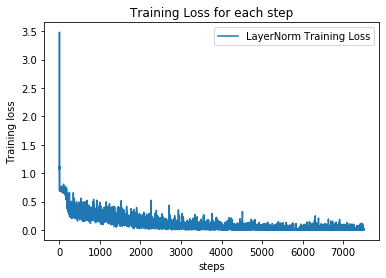

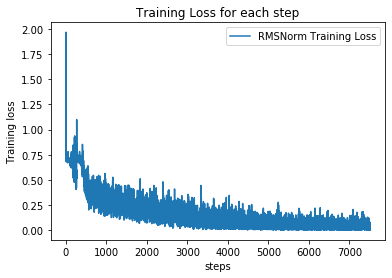

In [55]:
plt.plot(steps,model1trainloss[:len(steps)],label='LayerNorm Training Loss')
plt.title('Training Loss for each step')
plt.ylabel('Training loss')
plt.xlabel('steps')
plt.legend()
plt.show()

plt.plot(steps,model2trainloss[:len(steps)],label='RMSNorm Training Loss')
plt.title('Training Loss for each step')
plt.ylabel('Training loss')
plt.xlabel('steps')
plt.legend()
plt.show()

##### **Plot Validation Loss for Both the models**

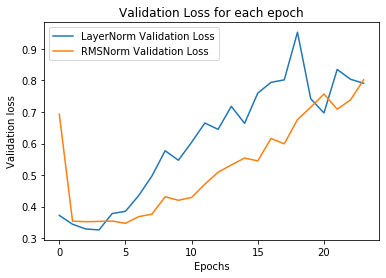

In [56]:
plt.plot(iterations,model1valloss[:len(iterations)],label='LayerNorm Validation Loss')
plt.plot(iterations,model2valloss[:len(iterations)],label='RMSNorm Validation Loss')
plt.title('Validation Loss for each epoch')
plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

##### **Plot Validation Accuracy for Both the models**

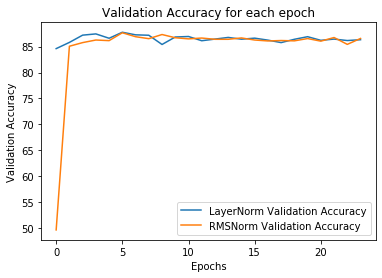

In [57]:
plt.plot(iterations,model1valacc[:len(iterations)],label='LayerNorm Validation Accuracy')
plt.plot(iterations,model2valacc[:len(iterations)],label='RMSNorm Validation Accuracy')
plt.title('Validation Accuracy for each epoch')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()